In [10]:
# Recorre todo el laberinto, colorear de otro color el camino que se ha recorrido, despues eliminar las oslas que bloquean y quedarnos unicamente con el camino libre, mostrar iteraciones ya que recorra cierta cantidad de puntos del laberinto

In [11]:
import copy
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from matplotlib.colors import ListedColormap


In [12]:
np.random.seed(42)
random.seed(42)

def generar_laberinto_conectado(filas, columnas):
    if filas % 2 == 0: filas += 1
    if columnas % 2 == 0: columnas += 1
    laberinto = [['1' for _ in range(columnas)] for _ in range(filas)]
    visitado = [[False for _ in range(columnas)] for _ in range(filas)]

    def vecinos(x, y):
        dirs = [(-2,0),(2,0),(0,-2),(0,2)]
        result = []
        for dx, dy in dirs:
            nx, ny = x+dx, y+dy
            if 0 <= nx < filas and 0 <= ny < columnas and not visitado[nx][ny]:
                result.append((nx, ny))
        random.shuffle(result)
        return result

    def dfs(x, y):
        visitado[x][y] = True
        laberinto[x][y] = '0'
        for nx, ny in vecinos(x, y):
            if not visitado[nx][ny]:
                laberinto[(x+nx)//2][(y+ny)//2] = '0'
                dfs(nx, ny)

    dfs(1, 1)

    for i in range(3, filas-1, 4):
        for j in range(3, columnas-1, 4):
            if random.random() < 0.3:
                if i > 0 and laberinto[i-1][j] == '1':
                    laberinto[i-1][j] = '0'
                elif j > 0 and laberinto[i][j-1] == '1':
                    laberinto[i][j-1] = '0'
    return laberinto

laberinto_conectado = generar_laberinto_conectado(20, 20)
for fila in laberinto_conectado:
    print(''.join(fila))


111111111111111111111
100000100010000010001
111010101010111010101
100000001000100000101
101111101111101111101
100000101000000000001
111110101110101111111
100000100000100010001
101111111010111011101
100000001010001000101
111011101110101110101
100000001000001010101
101010101011111010101
101010100010000010101
111010101110111010101
100010100000100010001
101110101011101111101
101000101010000010001
101111101010111110111
100000001000000000001
111111111111111111111


# Convertir el laberinto a un array NumPy para visualizarlo

In [13]:
# 0 = libre, 1 = pared, 2 = visitado (gris)
cmap = ListedColormap([[1,1,1], [0,0,0], [0.6,0.6,0.6]])

def to_numeric_grid(lab):
    h, w = len(lab), len(lab[0])
    M = np.zeros((h, w), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            M[i, j] = 1 if lab[i][j] == '1' else 0
    return M

def draw_state(ax, base_grid, visited_set, title):
    img = base_grid.copy().astype(np.uint8)   # 0/1
    for (r, c) in visited_set:
        if base_grid[r, c] == 0:
            img[r, c] = 2                    # gris
    img[base_grid == 1] = 1                  # asegurar muros negros
    ax.imshow(img, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    ax.set_title(title)
    ax.axis('off')

base = to_numeric_grid(laberinto_conectado)


# Algoritmo de resolución del laberinto

In [14]:
def astar(grid, start, goal):
    if start == goal: return [start]
    h, w = grid.shape
    def hfun(a,b): return abs(a[0]-b[0]) + abs(a[1]-b[1])
    open_heap = []
    heappush(open_heap, (hfun(start, goal), 0, start))
    came, g, open_set = {}, {start:0}, {start}
    while open_heap:
        _, gcur, cur = heappop(open_heap)
        if cur == goal:
            path = [cur]
            while cur in came:
                cur = came[cur]; path.append(cur)
            return list(reversed(path))
        open_set.discard(cur)
        r,c = cur
        for dr,dc in ((1,0),(-1,0),(0,1),(0,-1)):
            nr,nc = r+dr, c+dc
            if not (0<=nr<h and 0<=nc<w): continue
            if grid[nr,nc] == 1: continue
            ng = gcur + 1
            nxt = (nr,nc)
            if ng < g.get(nxt, 1<<30):
                came[nxt] = cur; g[nxt] = ng
                f = ng + hfun(nxt, goal)
                if nxt not in open_set:
                    heappush(open_heap, (f, ng, nxt)); open_set.add(nxt)
    return []

def primera_libre(grid):
    h,w = grid.shape
    for i in range(h):
        for j in range(w):
            if grid[i,j] == 0:
                return (i,j)
    return None

def vecinos4(grid, r, c):
    for dr,dc in ((1,0),(-1,0),(0,1),(0,-1)):
        nr,nc = r+dr, c+dc
        if 0<=nr<grid.shape[0] and 0<=nc<grid.shape[1]:
            yield (nr,nc)

def fill_all_with_astar(grid):
    start = primera_libre(grid)
    if start is None: return [], set()
    libres_total = int(np.sum(grid==0))
    visited = {start}
    cur = start

    def frontier():
        F=set()
        for (r,c) in visited:
            for (nr,nc) in vecinos4(grid,r,c):
                if grid[nr,nc]==0 and (nr,nc) not in visited:
                    F.add((nr,nc))
        return F

    F = frontier()
    milestones = [int(libres_total*0.3), int(libres_total*0.6), int(libres_total*0.9)]
    snaps=[]

    while len(visited)<libres_total and F:
        goal = min(F, key=lambda p: abs(p[0]-cur[0])+abs(p[1]-cur[1]))
        path = astar(grid, cur, goal)
        if not path:
            F.discard(goal); continue
        for cell in path: visited.add(cell)
        cur = goal
        F = frontier()
        while milestones and len(visited) >= milestones[0]:
            snaps.append(set(visited)); milestones.pop(0)

    while len(snaps)<3: snaps.append(set(visited))
    return snaps, visited

snapshots, visited_final = fill_all_with_astar(base)


# Muestra parcialmente la ruta tomada.

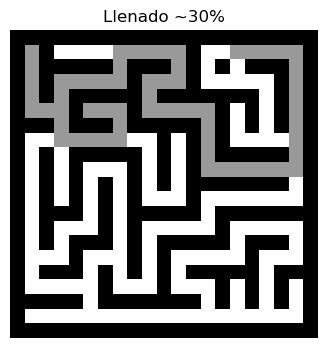

In [15]:
# Generar laberinto
lab = generar_laberinto_conectado(20, 20)
base = to_numeric_grid(lab)

# Rellenar hasta snapshots
snapshots, visited_final = fill_all_with_astar(base)

# Mostrar solo el 30 %
plt.figure(figsize=(4,4))
draw_state(plt.gca(), base, snapshots[0], "Llenado ~30%")
plt.show()


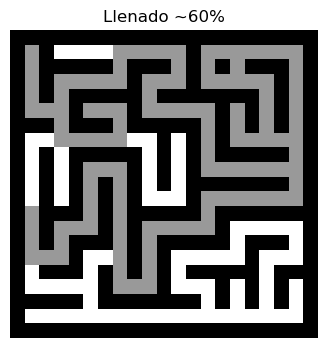

In [16]:
# Mostrar solo el 60 %
plt.figure(figsize=(4,4))
draw_state(plt.gca(), base, snapshots[1], "Llenado ~60%")
plt.show()


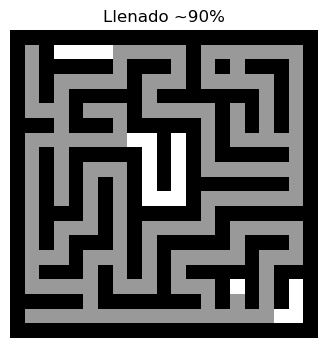

In [17]:
# Mostrar solo el 90 %
plt.figure(figsize=(4,4))
draw_state(plt.gca(), base, snapshots[2], "Llenado ~90%")
plt.show()


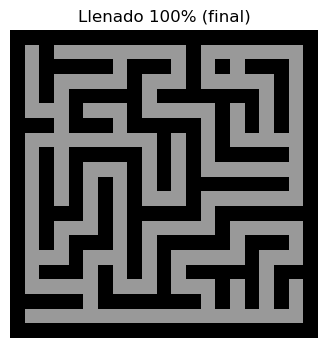

In [18]:
# Muestra el recorrido del laberinto completo 
plt.figure(figsize=(4,4))
draw_state(plt.gca(), base, visited_final, "Llenado 100% (final)")
plt.show()